# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "ana0910s1_long"   # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 100

##########################################################################



import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(5761, 32, 32, 3)
(5761, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Conv2D(32, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (5, 5), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(2))
model.summary()

model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 32, 32, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 32)         0         
 2D)                                                             
                                                        

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 100
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Epoch 1/100


/var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/ipykernel_84415/65716224.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
2022-07-15 20:27:24.668376: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


721/721 [==============================] - 3s 4ms/step - loss: 0.1653 - accuracy: 0.8474 - val_loss: 0.0191 - val_accuracy: 0.9705
Epoch 2/100
721/721 [==============================] - 3s 4ms/step - loss: 0.0179 - accuracy: 0.9660 - val_loss: 0.0119 - val_accuracy: 0.9792
Epoch 3/100
721/721 [==============================] - 3s 4ms/step - loss: 0.0087 - accuracy: 0.9773 - val_loss: 0.0077 - val_accuracy: 0.9714
Epoch 4/100
721/721 [==============================] - 3s 4ms/step - loss: 0.0059 - accuracy: 0.9797 - val_loss: 0.0032 - val_accuracy: 0.9896
Epoch 5/100
721/721 [==============================] - 3s 4ms/step - loss: 0.0040 - accuracy: 0.9847 - val_loss: 0.0055 - val_accuracy: 0.9931
Epoch 6/100
721/721 [==============================] - 3s 4ms/step - loss: 0.0032 - accuracy: 0.9839 - val_loss: 0.0032 - val_accuracy: 0.9887
Epoch 7/100
721/721 [==============================] - 3s 4ms/step - loss: 0.0026 - accuracy: 0.9892 - val_loss: 0.0030 - val_accuracy: 0.9748
Epoch 8/100

### Step 1: Learing result
 
* Visualization of the training and validation results

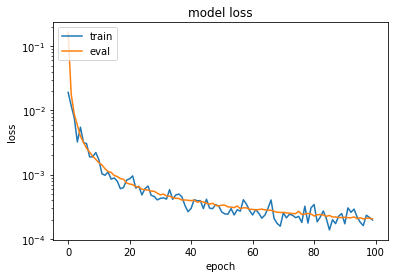

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)

plt.semilogy(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 400
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)


Epoch 1/400
 36/721 [>.............................] - ETA: 3s - loss: 0.1832 - accuracy: 0.8611

/var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/ipykernel_84415/3361052463.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)


721/721 [==============================] - 4s 5ms/step - loss: 0.0348 - accuracy: 0.9472 - val_loss: 0.0075 - val_accuracy: 0.9792
Epoch 2/400
721/721 [==============================] - 3s 5ms/step - loss: 0.0077 - accuracy: 0.9759 - val_loss: 0.0035 - val_accuracy: 0.9818
Epoch 3/400
721/721 [==============================] - 3s 5ms/step - loss: 0.0047 - accuracy: 0.9780 - val_loss: 0.0029 - val_accuracy: 0.9827
Epoch 4/400
721/721 [==============================] - 3s 5ms/step - loss: 0.0033 - accuracy: 0.9799 - val_loss: 0.0029 - val_accuracy: 0.9896
Epoch 5/400
721/721 [==============================] - 3s 5ms/step - loss: 0.0030 - accuracy: 0.9868 - val_loss: 0.0025 - val_accuracy: 0.9887
Epoch 6/400
721/721 [==============================] - 4s 5ms/step - loss: 0.0023 - accuracy: 0.9856 - val_loss: 0.0025 - val_accuracy: 0.9913
Epoch 7/400
721/721 [==============================] - 4s 5ms/step - loss: 0.0021 - accuracy: 0.9861 - val_loss: 0.0026 - val_accuracy: 0.9896
Epoch 8/400

### Overall Learing results (Step 1 & Step 2)

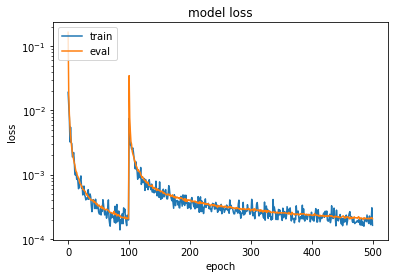

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])


if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [8]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = sorted(glob.glob(Input_dir + '/*.*'))
res = []
stat_Anz = []
stat_Abweichung = []
i = 0
deviation_max_list = 0.05

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for aktfile in sorted(files):
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
            
    target_int = int ((float(base[0:3])) * 10)
    stat_Abweichung[target_int] = stat_Abweichung[target_int] + dev_target  
    stat_Anz[target_int] = stat_Anz[target_int] + 1
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))

    
for i in range(100):
    stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res

data_resize_all/0.1_PRODUCED_ANALOG_2.jpg 0.01 0.19911532531326115 -0.18911532531326114


## Results

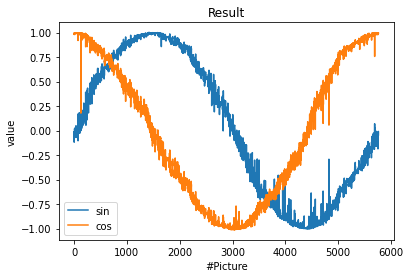

In [9]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

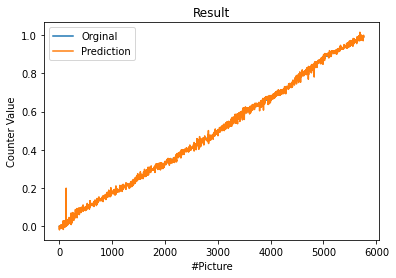

In [10]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

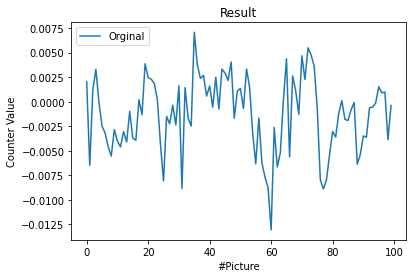

In [11]:
plt.plot(stat_Abweichung)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

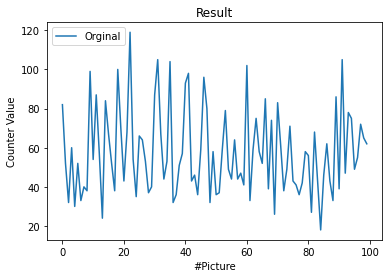

In [12]:
plt.plot(stat_Anz)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

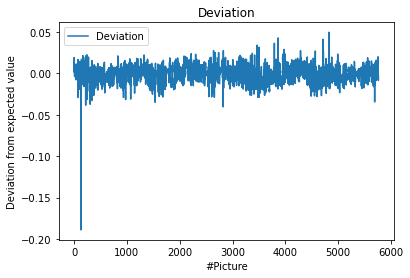

[-0.0012  0.0089 -0.1891  0.0495]


In [13]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [14]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

2022-07-15 21:05:44.598346: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmp7prxuda2/assets


2022-07-15 21:05:48.329050: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-07-15 21:05:48.329063: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-07-15 21:05:48.330136: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmp7prxuda2
2022-07-15 21:05:48.332577: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-07-15 21:05:48.332593: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmp7prxuda2
2022-07-15 21:05:48.341646: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-07-15 21:05:48.414782: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmp7prxuda2
2022-07-

204200

In [15]:
from pathlib import Path
import tensorflow as tf

FileName = TFliteNamingAndVersion + "q" + ".tflite"

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[n], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpxrq44piw/assets


INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpxrq44piw/assets
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-07-15 21:05:52.578500: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-07-15 21:05:52.578520: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-07-15 21:05:52.578604: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpxrq44piw
2022-07-15 21:05:52.580020: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-07-15 21:05:52.580027: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedMode

ana0910s1_longq.tflite


58744